In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

# Verificação inicial

In [2]:
DB_PARAMS = {
    'host': 'localhost',
    'port': '5432',
    'database': 'busdata',
    'user': 'user',
    'password': 'pass',
}

DB_URL = f"postgresql://{DB_PARAMS['user']}:{DB_PARAMS['password']}@{DB_PARAMS['host']}:{DB_PARAMS['port']}/{DB_PARAMS['database']}"

engine = create_engine(DB_URL)
with engine.connect() as conn:
    print("Conexão com banco de dados bem-sucedida.")

Conexão com banco de dados bem-sucedida.


primeiro vamos observar os pontos de uma linha de ônibus em um dia para verificar que a conexão está correta

In [3]:
query = """
SELECT ordem, linha, datahoraservidor, velocidade, geom
FROM gps_2024_04_25
WHERE linha = '483'
"""

line_gdf = gpd.read_postgis(query, engine, geom_col='geom', crs="EPSG:4326")
line_gdf['ts'] = pd.to_datetime(line_gdf['datahoraservidor'], unit='ms')


line_gdf.head()

,ordem,linha,datahoraservidor,velocidade,geom,ts
0,B31075,483,1714032030000,22,POINT (-43.28159 -22.83448),2024-04-25 08:00:30
1,B31076,483,1714032092000,0,POINT (-43.30951 -22.80469),2024-04-25 08:01:32
2,B31075,483,1714032092000,0,POINT (-43.28432 -22.83694),2024-04-25 08:01:32
3,B31064,483,1714032092000,0,POINT (-43.27898 -22.82894),2024-04-25 08:01:32
4,B31045,483,1714032092000,0,POINT (-43.31009 -22.8046),2024-04-25 08:01:32


In [4]:
# Print de informações gerais
print("Número de registros:", len(line_gdf))
print("Linhas únicas:", line_gdf['linha'].nunique())
print("Ônibus únicos:", line_gdf['ordem'].nunique())
print("Período:", line_gdf['ts'].min(), "até", line_gdf['ts'].max())

Número de registros: 67625
Linhas únicas: 1
Ônibus únicos: 68
Período: 2024-04-25 08:00:30 até 2024-04-26 02:00:29


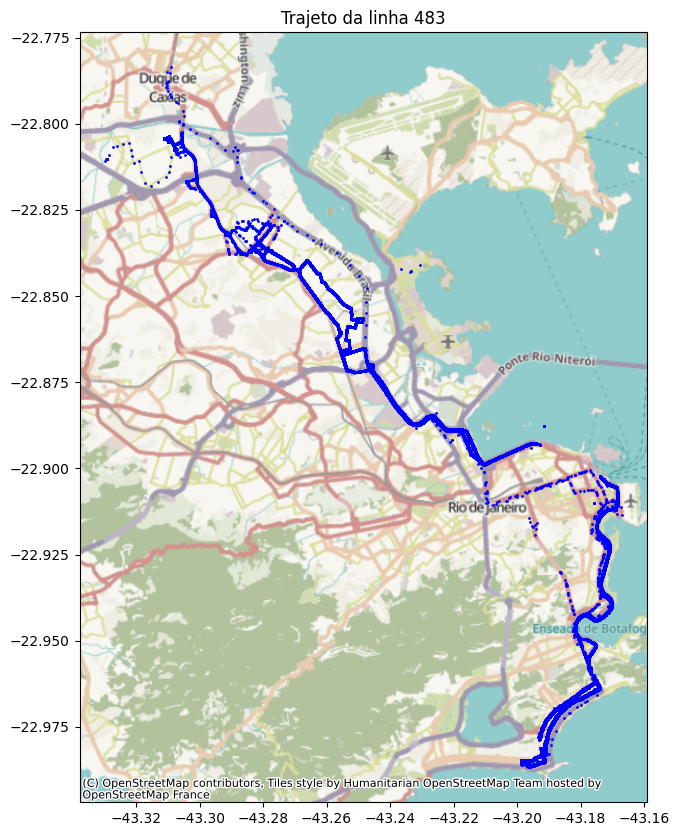

In [5]:
# Plotando o trajeto da linha 483
ax = line_gdf.plot(figsize=(12, 10), markersize=1, color='blue')
ctx.add_basemap(ax, crs=line_gdf.crs)
plt.title("Trajeto da linha 483")
plt.show()